##  Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
import os.path
from pathlib import Path

In [ ]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
from helper_functions import create_tensorboard_callback
from helper_functions import plot_loss_curves, unzip_data
from helper_functions import compare_historys, walk_through_dir, pred_and_plot

--2022-12-23 02:21:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-12-23 02:21:03 (70.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Loading and Transformation of Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

In [ ]:
dataset = '/content/gdrive/My Drive/Dataset/BagClasses/'
walk_through_dir(dataset)

There are 3 directories and 0 images in '/content/gdrive/My Drive/Dataset/BagClasses/'.
There are 0 directories and 5000 images in '/content/gdrive/My Drive/Dataset/BagClasses/Garbage Bag Images'.
There are 0 directories and 5000 images in '/content/gdrive/My Drive/Dataset/BagClasses/Paper Bag Images'.
There are 0 directories and 5000 images in '/content/gdrive/My Drive/Dataset/BagClasses/Plastic Bag Images'.


In [ ]:
image_dir = Path(dataset)
# Extracting filepaths and label information
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
# Concatenating filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
image_df

,Filepath,Label
0,/content/gdrive/My Drive/Dataset/BagClasses/Ga...,Garbage Bag Images
1,/content/gdrive/My Drive/Dataset/BagClasses/Ga...,Garbage Bag Images
2,/content/gdrive/My Drive/Dataset/BagClasses/Ga...,Garbage Bag Images
3,/content/gdrive/My Drive/Dataset/BagClasses/Ga...,Garbage Bag Images
4,/content/gdrive/My Drive/Dataset/BagClasses/Ga...,Garbage Bag Images
...,...,...
14995,/content/gdrive/My Drive/Dataset/BagClasses/Pl...,Plastic Bag Images
14996,/content/gdrive/My Drive/Dataset/BagClasses/Pl...,Plastic Bag Images
14997,/content/gdrive/My Drive/Dataset/BagClasses/Pl...,Plastic Bag Images
14998,/content/gdrive/My Drive/Dataset/BagClasses/Pl...,Plastic Bag Images


## Data Visualization

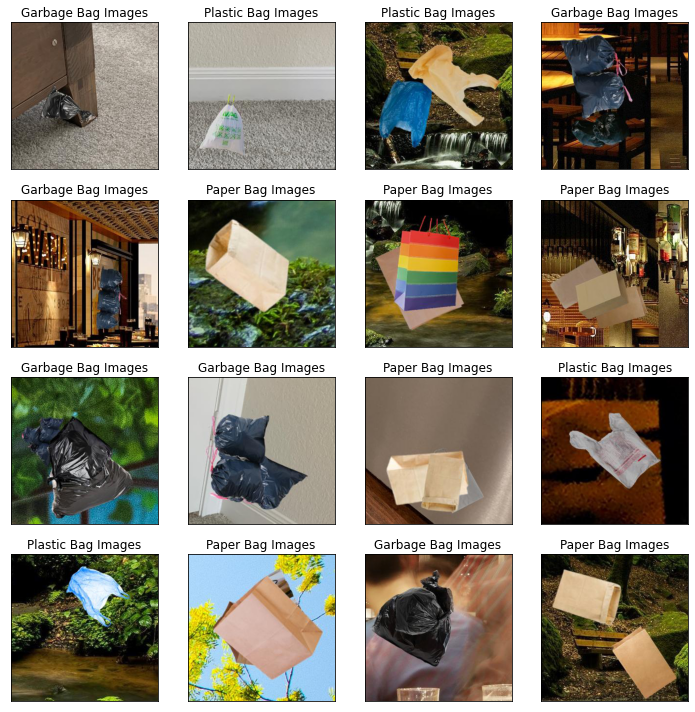

In [ ]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

## Data Preprocessing


In [ ]:
train_df, test_df = train_test_split(image_df, test_size=0.2,
                                     shuffle=True, random_state=42)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.25
)
test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 9000 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.


In [ ]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
])

## Training the model
The model images will be subjected to a pre-trained CNN model called MobileNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:

**Batch size** : 32

**Epochs** : 100

**Input Shape** : (300, 300, 3)

**Output layer** : 5



In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Create checkpoint callback
checkpoint_path = "bags_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training
# if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss",
                               patience = 5,
                               restore_best_weights = True)

In [ ]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(3, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=15,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "bag_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/bag_classification/20221223-030202
Epoch 1/15
282/282 [==============================] - 2961s 10s/step - loss: 0.2976 - accuracy: 0.8868 - val_loss: 0.0961 - val_accuracy: 0.9670
Epoch 2/15
282/282 [==============================] - 458s 2s/step - loss: 0.0938 - accuracy: 0.9676 - val_loss: 0.0643 - val_accuracy: 0.9790
Epoch 3/15
282/282 [==============================] - 462s 2s/step - loss: 0.0702 - accuracy: 0.9750 - val_loss: 0.0563 - val_accuracy: 0.9797
Epoch 4/15
282/282 [==============================] - 460s 2s/step - loss: 0.0490 - accuracy: 0.9829 - val_loss: 0.0518 - val_accuracy: 0.9810
Epoch 5/15
282/282 [==============================] - 459s 2s/step - loss: 0.0406 - accuracy: 0.9873 - val_loss: 0.0509 - val_accuracy: 0.9833
Epoch 6/15
282/282 [==============================] - 457s 2s/step - loss: 0.0292 - accuracy: 0.9911 - val_loss: 0.0489 - val_accuracy: 0.9830
Epoch 7/15
282/282 [==============================] - 455s

## Model Evaluation
The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:

**Precision(P)**:
The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.

<center>$P=TP/(TP+FP)$</center>

**Recall(R)**:
The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.
<center>$R=TP/(TP+FN)$</center>

**F1 score(F1)**:
The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.
<center>$F1=2 * (TP * FP)/(TP+FP)$</center>



In [ ]:
results = model.evaluate(test_images, verbose=0)
print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.06749
Test Accuracy: 97.90%


## Visualizing loss curves

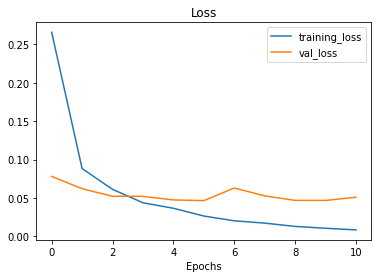

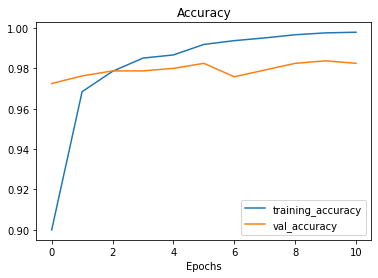

In [ ]:
plot_loss_curves(history)

## Predictions on the Test Data

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['Paper Bag Images', 'Paper Bag Images', 'Plastic Bag Images', 'Garbage Bag Images', 'Paper Bag Images']


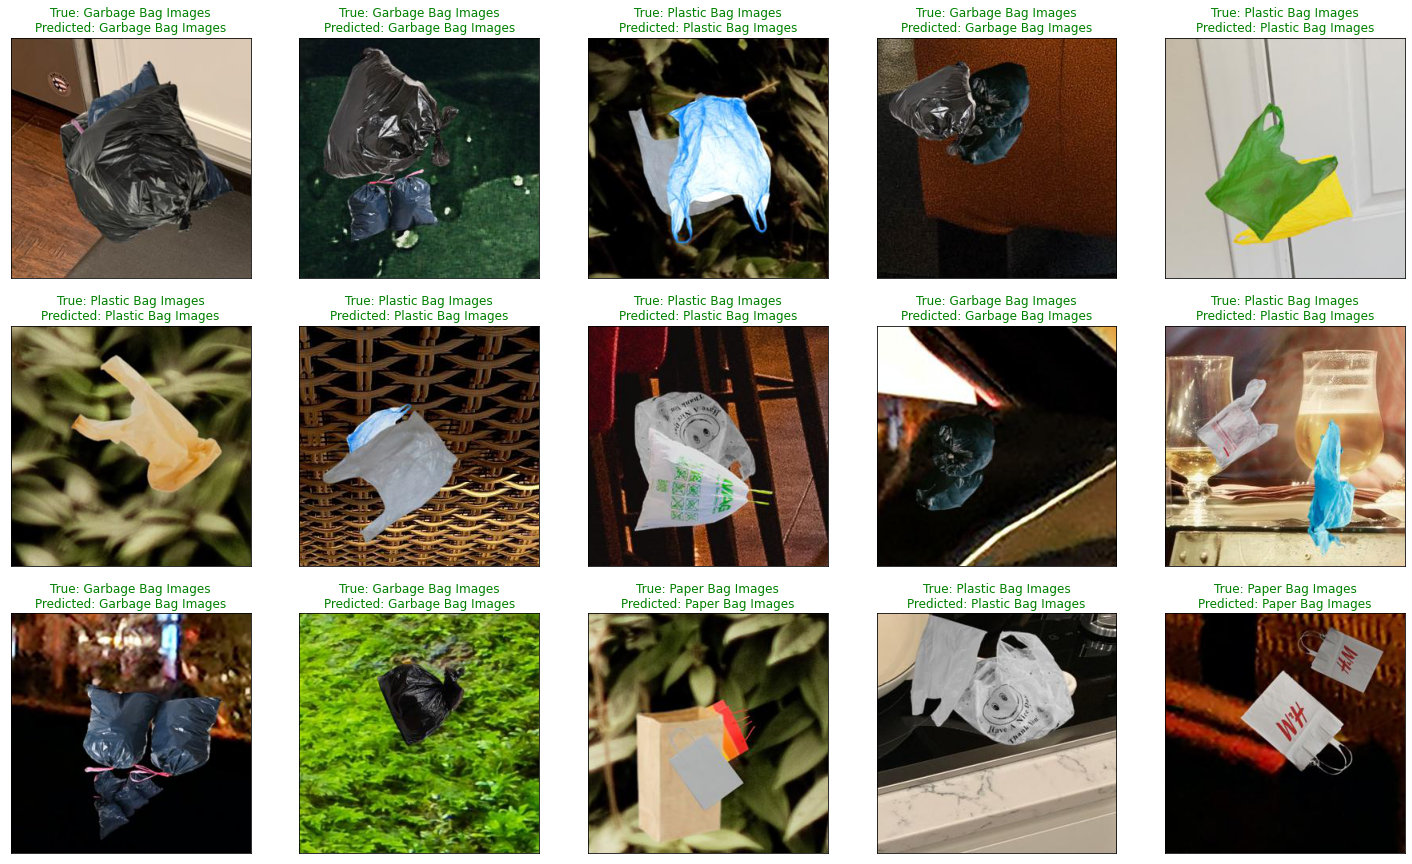

<Figure size 432x288 with 0 Axes>

In [ ]:
  # Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

## Plotting the Classification Reports and Confusion Matrix

In [ ]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                    precision    recall  f1-score   support

Garbage Bag Images       1.00      0.98      0.99      1037
  Paper Bag Images       0.98      0.98      0.98       970
Plastic Bag Images       0.96      0.98      0.97       993

          accuracy                           0.98      3000
         macro avg       0.98      0.98      0.98      3000
      weighted avg       0.98      0.98      0.98      3000



In [ ]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
Garbage Bag Images,0.997056,0.979749,0.988327,1037.000
Paper Bag Images,0.981347,0.976289,0.978811,970.000
Plastic Bag Images,0.958661,0.980866,0.969637,993.000
accuracy,0.979000,0.979000,0.979000,0.979
macro avg,0.979022,0.978968,0.978925,3000.000
weighted avg,0.979268,0.979000,0.979064,3000.000


In [ ]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(15, 7), text_size=10, norm=False, savefig=False):
  # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
    plt.xticks(rotation=90, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size)
        else:
            plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")


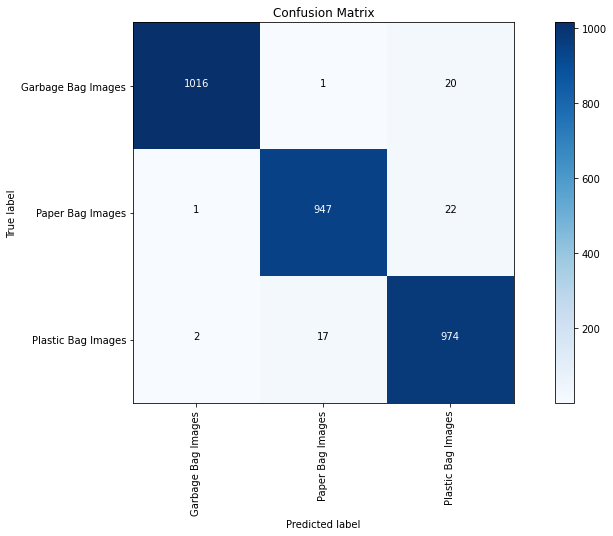

In [ ]:
make_confusion_matrix(y_test, pred, list(labels.values()))